In [1]:
import numpy as np
import qiskit
from qiskit import IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit import Aer
import qiskit.providers.aer.noise as noise
from qiskit.extensions import XGate, YGate, ZGate, CnotGate, RZGate, HGate, SwapGate, TGate, IdGate, CzGate, UnitaryGate
from qiskit.quantum_info.operators import Operator, Pauli
import pandas as pd
import random
import time
import datetime
import os

#matplot stuff
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import make_interp_spline, BSpline

# QuaEC: Library for Quantum Error Correction
import qecc as q


class URB:

    # global variables
    __PROVIDER = IBMQ.load_account()
    __SIMULATOR_1 = BasicAer.get_backend('qasm_simulator')
    __SIMULATOR_2 = Aer.get_backend('qasm_simulator')
    __BACKEND = __PROVIDER.get_backend('ibmq_burlington')
    __CURR_DIR = os.getcwd()

    # Globally defining labels for measurement, state preparation and Applying unitary operations
    __STATE_PREPARATION_1 = 'state_prep_1'   # state prep single qubit label
    __STATE_PREPARATION_2 = 'state_prep_2'   # state prep two qubit label
    __CLIFFORD_GATE_1 = 'clifford_1'         # clifford error single qubit label
    __CLIFFORD_GATE_2 = 'clifford_2'         # clifford error two qubit label
    __GATE_OPERATION_1 = 'normal_1'          # normal gate error single qubit label
    __GATE_OPERATION_2 = 'normal_2'          # normal gate error two qubit label
    __MEASUREMENT_1 = 'measure_1'            # measurement error single qubit label
    __MEASUREMENT_2 = 'measure_2'            # measurement error two qubit label




    __val = 1/pow(2,0.5)
    __HADAMARD_Y_MEASURE = UnitaryGate([[__val, __val*(0 - 1.j)], [__val*(0 + 1.j), (-1)*__val]], label = 'Hadamard_Y_measure')
    __HADAMARD_Y_STATE_PREP = UnitaryGate([[__val, __val], [__val*(0 + 1.j), __val*(0 - 1.j)]], label = 'Hadamard_Y_state_prep')

    
    def __init__(self, curr_dir = None, output_folder_name = None, num_qubits = None, shots = None):
        if output_folder_name != None:
            self.output_folder_name = output_folder_name
        else:
            self.output_folder_name = ""
        if num_qubits != None:
            self.num_qubits = num_qubits
        else:
            self.num_qubits = 1
        if shots != None:
            self.shots = shots
        else:
            self.shots = 1024
        if curr_dir != None:
            self.__CURR_DIR = curr_dir
        self._start_time = 0
        self._end_time = 0
        self._depths = None
        self.avg_shifted_purities = None
        self.shifted_purities = None
        self._iterations = None
        self._samples = None
    
    
    
    # Generate unitary 2-design Gate set for benchmarking, We have used Clifford Group as our 2-design.
    def __generateGateSet(self):
        clifford_elements = []
        gen = q.clifford_group(self.num_qubits, True)   
        for gate in gen:
            clifford_elements.append(gate)
        return clifford_elements



    # prepare initial state, (I+P)/d and (I-P)/d
    def __initialize(self, gate_index):
        circuits = []
        Qregisters = []
        Cregisters = []
        n = self.num_qubits
        STATE_PREPARATION_1 = self.__STATE_PREPARATION_1
        STATE_PREPARATION_2 = self.__STATE_PREPARATION_2
        HadamardY_state_prep = self.__HADAMARD_Y_STATE_PREP


        for _ in range(2*n):
            qr = QuantumRegister(n)
            cr = ClassicalRegister(n)
            circuits.append(QuantumCircuit(qr, cr))
            Qregisters.append(qr)
            Cregisters.append(cr)

        if n == 1:
            if gate_index == 1:
                # +
                circuits[0].unitary(HGate().to_matrix(), [Qregisters[0][0]], STATE_PREPARATION_1)
                # -
                circuits[1].unitary(XGate().to_matrix(), [Qregisters[1][0]], STATE_PREPARATION_1)
                circuits[1].unitary(HGate().to_matrix(), [Qregisters[1][0]], STATE_PREPARATION_1)

            elif gate_index == 2:
                # +'
                circuits[0].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[0][0]], STATE_PREPARATION_1)
                # -'
                circuits[1].unitary(XGate().to_matrix(), [Qregisters[1][0]], STATE_PREPARATION_1)
                circuits[1].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[1][0]], STATE_PREPARATION_1)

            elif gate_index == 3:
                # 0
                circuits[0].unitary(IdGate().to_matrix(), [Qregisters[0][0]], STATE_PREPARATION_1)
                # 1
                circuits[1].unitary(XGate().to_matrix(), [Qregisters[1][0]], STATE_PREPARATION_1)

        if n == 2:
            if gate_index == 1:      # I, X
                # 0, +
                circuits[0].unitary(IdGate().to_matrix(), [Qregisters[0][0]], STATE_PREPARATION_1)
                circuits[0].unitary(HGate().to_matrix(), [1], STATE_PREPARATION_1)
                # 1, +
                circuits[1].unitary(XGate().to_matrix(), [Qregisters[1][0]], STATE_PREPARATION_1)
                circuits[1].unitary(HGate().to_matrix(), [Qregisters[1][1]], STATE_PREPARATION_1)
                # 0, -
                circuits[2].unitary(IdGate().to_matrix(), [Qregisters[2][0]], STATE_PREPARATION_1)
                circuits[2].unitary(XGate().to_matrix(), [Qregisters[2][1]], STATE_PREPARATION_1)
                circuits[2].unitary(HGate().to_matrix(), [Qregisters[2][1]], STATE_PREPARATION_1)
                # 1, -
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][0]], STATE_PREPARATION_1)
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][1]], STATE_PREPARATION_1)
                circuits[3].unitary(HGate().to_matrix(), [Qregisters[3][1]], STATE_PREPARATION_1)

            elif gate_index == 2:    # I, Y
                # 0, +'
                circuits[0].unitary(IdGate().to_matrix(), [Qregisters[0][0]], STATE_PREPARATION_1)
                circuits[0].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[0][1]], STATE_PREPARATION_1)
                # 1, +'
                circuits[1].unitary(XGate().to_matrix(), [Qregisters[1][0]], STATE_PREPARATION_1)
                circuits[1].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[1][1]], STATE_PREPARATION_1)
                # 0, -'
                circuits[2].unitary(IdGate().to_matrix(), [Qregisters[2][0]], STATE_PREPARATION_1)
                circuits[2].unitary(XGate().to_matrix(), [Qregisters[2][1]], STATE_PREPARATION_1)
                circuits[2].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[2][1]], STATE_PREPARATION_1)
                # 1, -'
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][0]], STATE_PREPARATION_1)
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][1]], STATE_PREPARATION_1)
                circuits[3].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[3][1]], STATE_PREPARATION_1)

            elif gate_index == 3:    # I, Z
                # 0, 0
                circuits[0].unitary(IdGate().to_matrix(), [Qregisters[0][0]], STATE_PREPARATION_1)
                circuits[0].unitary(IdGate().to_matrix(), [Qregisters[0][1]], STATE_PREPARATION_1)
                # 1, 0
                circuits[1].unitary(XGate().to_matrix(), [Qregisters[1][0]], STATE_PREPARATION_1)
                circuits[1].unitary(IdGate().to_matrix(), [Qregisters[1][1]], STATE_PREPARATION_1)
                # 0, 1
                circuits[2].unitary(IdGate().to_matrix(), [Qregisters[2][0]], STATE_PREPARATION_1)
                circuits[2].unitary(XGate().to_matrix(), [Qregisters[2][1]], STATE_PREPARATION_1)
                # 1, 1
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][0]], STATE_PREPARATION_1)
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][1]], STATE_PREPARATION_1)

            elif gate_index == 4:    # X, I
                # +, 0
                circuits[0].unitary(IdGate().to_matrix(), [Qregisters[0][1]], STATE_PREPARATION_1)
                circuits[0].unitary(HGate().to_matrix(), [Qregisters[0][0]], STATE_PREPARATION_1)
                # +, 1
                circuits[1].unitary(XGate().to_matrix(), [Qregisters[1][1]], STATE_PREPARATION_1)
                circuits[1].unitary(HGate().to_matrix(), [Qregisters[1][0]], STATE_PREPARATION_1)
                # -, 0
                circuits[2].unitary(IdGate().to_matrix(), [Qregisters[2][1]], STATE_PREPARATION_1)
                circuits[2].unitary(XGate().to_matrix(), [Qregisters[2][0]], STATE_PREPARATION_1)
                circuits[2].unitary(HGate().to_matrix(), [Qregisters[2][0]], STATE_PREPARATION_1)
                # -, 1
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][1]], STATE_PREPARATION_1)
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][0]], STATE_PREPARATION_1)
                circuits[3].unitary(HGate().to_matrix(), [Qregisters[3][0]], STATE_PREPARATION_1)

            elif gate_index == 5:    # Y, I
                # +', 0
                circuits[0].unitary(IdGate().to_matrix(), [Qregisters[0][1]], STATE_PREPARATION_1)
                circuits[0].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[0][0]], STATE_PREPARATION_1)
                # +', 1
                circuits[1].unitary(XGate().to_matrix(), [Qregisters[1][1]], STATE_PREPARATION_1)
                circuits[1].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[1][0]], STATE_PREPARATION_1)
                # -', 0
                circuits[2].unitary(IdGate().to_matrix(), [Qregisters[2][1]], STATE_PREPARATION_1)
                circuits[2].unitary(XGate().to_matrix(), [Qregisters[2][0]], STATE_PREPARATION_1)
                circuits[2].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[2][0]], STATE_PREPARATION_1)
                # -', 1
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][1]], STATE_PREPARATION_1)
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][0]], STATE_PREPARATION_1)
                circuits[3].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[3][0]], STATE_PREPARATION_1)


            elif gate_index == 6:    # Z, I
                # 0, 0
                circuits[0].unitary(IdGate().to_matrix(), [Qregisters[0][0]], STATE_PREPARATION_1)
                circuits[0].unitary(IdGate().to_matrix(), [Qregisters[0][1]], STATE_PREPARATION_1)
                # 0, 1
                circuits[1].unitary(XGate().to_matrix(), [Qregisters[1][1]], STATE_PREPARATION_1)
                circuits[1].unitary(IdGate().to_matrix(), [Qregisters[1][0]], STATE_PREPARATION_1)
                # 1, 0
                circuits[2].unitary(IdGate().to_matrix(), [Qregisters[2][1]], STATE_PREPARATION_1)
                circuits[2].unitary(XGate().to_matrix(), [Qregisters[2][0]], STATE_PREPARATION_1)
                # 1, 1
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][0]], STATE_PREPARATION_1)
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][1]], STATE_PREPARATION_1)

            elif gate_index == 7:    # X, X
                # psi+
                circuits[0].unitary(HGate().to_matrix(), [Qregisters[0][0]], STATE_PREPARATION_1)
                circuits[0].unitary(CnotGate().to_matrix(), [Qregisters[0][0], Qregisters[0][1]], STATE_PREPARATION_2)
                # phi+
                circuits[1].unitary(HGate().to_matrix(), [Qregisters[1][0]], STATE_PREPARATION_1)
                circuits[1].unitary(XGate().to_matrix(), [Qregisters[1][1]], STATE_PREPARATION_1)
                circuits[1].unitary(CnotGate().to_matrix(), [Qregisters[1][0], Qregisters[1][1]], STATE_PREPARATION_2)
                # psi-
                circuits[2].unitary(XGate().to_matrix(), [Qregisters[2][0]], STATE_PREPARATION_1)
                circuits[2].unitary(HGate().to_matrix(), [Qregisters[2][0]], STATE_PREPARATION_1)
                circuits[2].unitary(CnotGate().to_matrix(), [Qregisters[2][0], Qregisters[2][1]], STATE_PREPARATION_2)
                # phi-
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][0]], STATE_PREPARATION_1)
                circuits[3].unitary(HGate().to_matrix(), [Qregisters[3][0]], STATE_PREPARATION_1)
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][1]], STATE_PREPARATION_1)
                circuits[3].unitary(CnotGate().to_matrix(), [Qregisters[3][0], Qregisters[3][1]], STATE_PREPARATION_2)

            elif gate_index == 8:    # Y, Y
                # phi+
                circuits[0].unitary(HGate().to_matrix(), [Qregisters[0][0]], STATE_PREPARATION_1)
                circuits[0].unitary(XGate().to_matrix(), [Qregisters[0][1]], STATE_PREPARATION_1)
                circuits[0].unitary(CnotGate().to_matrix(), [Qregisters[0][0], Qregisters[0][1]], STATE_PREPARATION_2)
                # psi-
                circuits[1].unitary(XGate().to_matrix(), [Qregisters[1][0]], STATE_PREPARATION_1)
                circuits[1].unitary(HGate().to_matrix(), [Qregisters[1][0]], STATE_PREPARATION_1)
                circuits[1].unitary(CnotGate().to_matrix(), [Qregisters[1][0], Qregisters[1][1]], STATE_PREPARATION_2)
                # psi+
                circuits[2].unitary(HGate().to_matrix(), [Qregisters[2][0]], STATE_PREPARATION_1)
                circuits[2].unitary(CnotGate().to_matrix(), [Qregisters[2][0], Qregisters[2][1]], STATE_PREPARATION_2)
                # phi-
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][0]], STATE_PREPARATION_1)
                circuits[3].unitary(HGate().to_matrix(), [Qregisters[3][0]], STATE_PREPARATION_1)
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][1]], STATE_PREPARATION_1)
                circuits[3].unitary(CnotGate().to_matrix(), [Qregisters[3][0], Qregisters[3][1]], STATE_PREPARATION_2)
            elif gate_index == 9:    # Z, Z
                # 0, 0
                circuits[0].unitary(IdGate().to_matrix(), [Qregisters[0][0]], STATE_PREPARATION_1)
                circuits[0].unitary(IdGate().to_matrix(), [Qregisters[0][1]], STATE_PREPARATION_1)
                # 1, 1
                circuits[1].unitary(XGate().to_matrix(), [Qregisters[1][0]], STATE_PREPARATION_1)
                circuits[1].unitary(XGate().to_matrix(), [Qregisters[1][1]], STATE_PREPARATION_1)
                # 1, 0
                circuits[2].unitary(XGate().to_matrix(), [Qregisters[2][0]], STATE_PREPARATION_1)
                circuits[2].unitary(IdGate().to_matrix(), [Qregisters[2][1]], STATE_PREPARATION_1)
                # 0, 1
                circuits[3].unitary(IdGate().to_matrix(), [Qregisters[3][0]], STATE_PREPARATION_1)
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][1]], STATE_PREPARATION_1)

            elif gate_index == 10:   # Y, X
                # ~psi+
                circuits[0].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[0][0]], STATE_PREPARATION_1)
                circuits[0].unitary(CnotGate().to_matrix(), [Qregisters[0][0], Qregisters[0][1]], STATE_PREPARATION_2)
                # ~phi+
                circuits[1].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[1][0]], STATE_PREPARATION_1)
                circuits[1].unitary(XGate().to_matrix(), [Qregisters[1][1]], STATE_PREPARATION_1)
                circuits[1].unitary(CnotGate().to_matrix(), [Qregisters[1][0], Qregisters[1][1]], STATE_PREPARATION_2)
                # ~psi-
                circuits[2].unitary(XGate().to_matrix(), [Qregisters[2][0]], STATE_PREPARATION_1)
                circuits[2].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[2][0]], STATE_PREPARATION_1)
                circuits[2].unitary(CnotGate().to_matrix(), [Qregisters[2][0], Qregisters[2][1]], STATE_PREPARATION_2)
                # ~phi-
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][0]], STATE_PREPARATION_1)
                circuits[3].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[3][0]], STATE_PREPARATION_1)
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][1]], STATE_PREPARATION_1)
                circuits[3].unitary(CnotGate().to_matrix(), [Qregisters[3][0], Qregisters[3][1]], STATE_PREPARATION_2)

            elif gate_index == 11:   # X, Y
                # ~psi+
                circuits[0].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[0][1]], STATE_PREPARATION_1)
                circuits[0].unitary(CnotGate().to_matrix(), [Qregisters[0][1], Qregisters[0][0]], STATE_PREPARATION_2)
                # ~phi+
                circuits[1].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[1][1]], STATE_PREPARATION_1)
                circuits[1].unitary(XGate().to_matrix(), [Qregisters[1][0]], STATE_PREPARATION_1)
                circuits[1].unitary(CnotGate().to_matrix(), [Qregisters[1][1], Qregisters[1][0]], STATE_PREPARATION_2)
                # ~psi-
                circuits[2].unitary(XGate().to_matrix(), [Qregisters[2][1]], STATE_PREPARATION_1)
                circuits[2].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[2][1]], STATE_PREPARATION_1)
                circuits[2].unitary(CnotGate().to_matrix(), [Qregisters[2][1], Qregisters[2][0]], STATE_PREPARATION_2)
                # ~phi-
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][1]], STATE_PREPARATION_1)
                circuits[3].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[3][1]], STATE_PREPARATION_1)
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][0]], STATE_PREPARATION_1)
                circuits[3].unitary(CnotGate().to_matrix(), [Qregisters[3][1], Qregisters[3][0]], STATE_PREPARATION_2)

            elif gate_index == 12:   # X, Z
                # +, 0
                circuits[0].unitary(IdGate().to_matrix(), [Qregisters[0][1]], STATE_PREPARATION_1)
                circuits[0].unitary(HGate().to_matrix(), [Qregisters[0][0]], STATE_PREPARATION_1)
                # -, 1
                circuits[1].unitary(XGate().to_matrix(), [Qregisters[1][1]], STATE_PREPARATION_1)
                circuits[1].unitary(XGate().to_matrix(), [Qregisters[1][0]], STATE_PREPARATION_1)
                circuits[1].unitary(HGate().to_matrix(), [Qregisters[1][0]], STATE_PREPARATION_1)
                # +, 1
                circuits[2].unitary(XGate().to_matrix(), [Qregisters[2][1]], STATE_PREPARATION_1)
                circuits[2].unitary(HGate().to_matrix(), [Qregisters[2][0]], STATE_PREPARATION_1)
                # -, 0
                circuits[3].unitary(IdGate().to_matrix(), [Qregisters[3][1]], STATE_PREPARATION_1)
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][0]], STATE_PREPARATION_1)
                circuits[3].unitary(HGate().to_matrix(), [Qregisters[3][0]], STATE_PREPARATION_1)

            elif gate_index == 13:   # Z, X
                # 0, +
                circuits[0].unitary(IdGate().to_matrix(), [Qregisters[0][0]], STATE_PREPARATION_1)
                circuits[0].unitary(HGate().to_matrix(), [Qregisters[0][1]], STATE_PREPARATION_1)
                # 1, -
                circuits[1].unitary(XGate().to_matrix(), [Qregisters[1][0]], STATE_PREPARATION_1)
                circuits[1].unitary(XGate().to_matrix(), [Qregisters[1][1]], STATE_PREPARATION_1)
                circuits[1].unitary(HGate().to_matrix(), [Qregisters[1][1]], STATE_PREPARATION_1)
                # 1, +
                circuits[2].unitary(XGate().to_matrix(), [Qregisters[2][0]], STATE_PREPARATION_1)
                circuits[2].unitary(HGate().to_matrix(), [Qregisters[2][1]], STATE_PREPARATION_1)
                # 0, -
                circuits[3].unitary(IdGate().to_matrix(), [Qregisters[3][0]], STATE_PREPARATION_1)
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][1]], STATE_PREPARATION_1)
                circuits[3].unitary(HGate().to_matrix(), [Qregisters[3][1]], STATE_PREPARATION_1)

            elif gate_index == 14:   # Y, Z
                # +', 0
                circuits[0].unitary(IdGate().to_matrix(), [Qregisters[0][1]], STATE_PREPARATION_1)
                circuits[0].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[0][0]], STATE_PREPARATION_1)
                # -', 1
                circuits[1].unitary(XGate().to_matrix(), [Qregisters[1][1]], STATE_PREPARATION_1)
                circuits[1].unitary(XGate().to_matrix(), [Qregisters[1][0]], STATE_PREPARATION_1)
                circuits[1].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[1][0]], STATE_PREPARATION_1)
                # +', 1
                circuits[2].unitary(XGate().to_matrix(), [Qregisters[2][1]], STATE_PREPARATION_1)
                circuits[2].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[2][0]], STATE_PREPARATION_1)
                # -', 0
                circuits[3].unitary(IdGate().to_matrix(), [Qregisters[3][1]], STATE_PREPARATION_1)
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][0]], STATE_PREPARATION_1)
                circuits[3].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[3][0]], STATE_PREPARATION_1)

            elif gate_index == 15:   # Z, Y
                # 0, +'
                circuits[0].unitary(IdGate().to_matrix(), [Qregisters[0][0]], STATE_PREPARATION_1)
                circuits[0].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[0][1]], STATE_PREPARATION_1)
                # 1, -'
                circuits[1].unitary(XGate().to_matrix(), [Qregisters[1][0]], STATE_PREPARATION_1)
                circuits[1].unitary(XGate().to_matrix(), [Qregisters[1][1]], STATE_PREPARATION_1)
                circuits[1].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[1][1]], STATE_PREPARATION_1)
                # 1, +'
                circuits[2].unitary(XGate().to_matrix(), [Qregisters[2][0]], STATE_PREPARATION_1)
                circuits[2].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[2][1]], STATE_PREPARATION_1)
                # 0, -'
                circuits[3].unitary(IdGate().to_matrix(), [Qregisters[3][0]], STATE_PREPARATION_1)
                circuits[3].unitary(XGate().to_matrix(), [Qregisters[3][1]], STATE_PREPARATION_1)
                circuits[3].unitary(HadamardY_state_prep.to_matrix(), [Qregisters[3][1]], STATE_PREPARATION_1)

        return circuits, Qregisters, Cregisters



    # Apply arbitrary n qubit Clifford Gate (n <= 2) from given Quasm Code specifying the Quantum Circuit design for the gate    
    def __applyClifford(self, qc, qr, quasm_string):
        possible_gates = ['I', 'X', 'Y', 'Z', 'H', 'R_pi4', 'CNOT', 'CZ', 'SWAP']
        gate_index = -1
        qubit_loc = []
        two_qubit_flag = False
        CLIFFORD_GATE_1 = self.__CLIFFORD_GATE_1
        CLIFFORD_GATE_2 = self.__CLIFFORD_GATE_2
        GATE_OPERATION_1 = self.__GATE_OPERATION_1
        GATE_OPERATION_2 = self.__GATE_OPERATION_2
        
        
        if quasm_string == None:
            return

        for index in range(len(quasm_string)):
            if quasm_string[index].isnumeric() == False:
                if quasm_string[index] == "!":
                    if len(qr) == 1:
                        qc.unitary(IdGate().to_matrix(), [qr[0]], CLIFFORD_GATE_1)
                    else:
                        qc.unitary(Operator(Pauli(label = 'II')).data, [qr[0],qr[1]], CLIFFORD_GATE_2)
                    continue
                if gate_index >= 0:
                    if two_qubit_flag == True and len(qubit_loc) == 1:
                        print("Quasm code is invalid: Expected two qubits for a two qubit gate, only one qubit supplied")
                    print("Quasm code is invalid: Consecutive gate operations without specifying the qubit locations is invalid")
                    return
                for i in range(len(possible_gates)):
                    if quasm_string[index] == possible_gates[i]:
                        gate_index = i
                        if i >= 6:
                            two_qubit_flag = True
                        break
                if gate_index == -1:
                    print("Quasm code is invalid: Gate ", quasm_string[index], " is not in the possible gates set")
                    return
            elif quasm_string[index].isnumeric() == True:
                if gate_index == -1:
                    print("Quasm code is invalid: Specifying qubit location without providing the gate to be applied")
                    return
                if len(qubit_loc) >= 2:
                    print("Quasm code is invalid: Only single and two-qubit gates are allowed, number of qubits supplied is exceeded")
                    return 
                qubit_loc.append(int(quasm_string[index]))
                if len(qubit_loc) == 1 and two_qubit_flag == False:
                    if gate_index == 0:
                        qc.unitary(IdGate().to_matrix(), [qr[qubit_loc[0]]], GATE_OPERATION_1)
                    elif gate_index == 1:
                        qc.unitary(XGate().to_matrix(), [qr[qubit_loc[0]]], GATE_OPERATION_1)
                    elif gate_index == 2:
                        qc.unitary(YGate().to_matrix(), [qr[qubit_loc[0]]], GATE_OPERATION_1)
                    elif gate_index == 3:
                        qc.unitary(ZGate().to_matrix(), [qr[qubit_loc[0]]], GATE_OPERATION_1)
                    elif gate_index == 4:
                        qc.unitary(HGate().to_matrix(), [qr[qubit_loc[0]]], GATE_OPERATION_1)
                    elif gate_index == 5:
                        qc.unitary(TGate().to_matrix(), [qr[qubit_loc[0]]], GATE_OPERATION_1)
                    gate_index = -1
                    qubit_loc = []
                    two_qubit_flag = False
                if len(qubit_loc) == 2 and two_qubit_flag == True:
                    if gate_index == 6:
                        qc.unitary(CnotGate().to_matrix(), [qr[qubit_loc[0]], qr[qubit_loc[1]]], GATE_OPERATION_2)
                    if gate_index == 7:
                        qc.unitary(CzGate().to_matrix(), [qr[qubit_loc[0]], qr[qubit_loc[1]]], GATE_OPERATION_2)
                    if gate_index == 8:
                        qc.unitary(SwapGate().to_matrix(), [qr[qubit_loc[0]], qr[qubit_loc[1]]], GATE_OPERATION_2)
                    gate_index = -1
                    qubit_loc = []
                    two_qubit_flag = False
            else:
                print("Quasm code is invalid: Invalid Character in the Quasm Instruction")
                return

   

    # To calculate the trace of non identity Pauli observable, by measuring in computational basis 
    def __get_measurable_states(self, circuits, Qregisters, gate_index):
        measure_indices = []     # this list contains the states whose probability is to be calculated 
                                 # '0' -> |0> for single qubit and '00' |00> for two qubit
                                 # '01' -> |01>, '10' -> |10>, '11' -> |11>

        n = self.num_qubits
        val = self.__val
        MEASUREMENT_1 = self.__MEASUREMENT_1
        MEASUREMENT_2 = self.__MEASUREMENT_2
        HadamardY_measure = self.__HADAMARD_Y_MEASURE

        if n == 1:
            measure_indices.append('0')
            if gate_index == 2:   # X
                for i in range(len(circuits)):
                    circuits[i].unitary(HGate().to_matrix(), [Qregisters[i][0]], MEASUREMENT_1)
            elif gate_index == 3:   # Y
                for i in range(len(circuits)):
                    circuits[i].unitary(HadamardY_measure.to_matrix(), [Qregisters[i][0]], MEASUREMENT_1)
        if n == 2:
            matrix = np.array([])
            p1 = p2 = None
            if gate_index == 1:  # X, I
                p1 = Pauli(label = 'XI')
                p2 = Pauli(label = 'ZI')
                matrix = (Operator(p1).data + Operator(p2).data)*val
                measure_indices.append('00')
                measure_indices.append('10')
            elif gate_index == 2:  # Y, I
                p1 = Pauli(label = 'YI')
                p2 = Pauli(label = 'ZI')
                matrix = (Operator(p1).data + Operator(p2).data)*val
                measure_indices.append('00')
                measure_indices.append('10')
            elif gate_index == 3:  # Z, I
                measure_indices.append('00')
                measure_indices.append('10')
            elif gate_index == 4:  # I, X
                p1 = Pauli(label = 'IX')
                p2 = Pauli(label = 'IZ')
                matrix = (Operator(p1).data + Operator(p2).data)*val
                measure_indices.append('00')
                measure_indices.append('01')
            elif gate_index == 5:  # I, Y
                p1 = Pauli(label = 'IY')
                p2 = Pauli(label = 'IZ')
                matrix = (Operator(p1).data + Operator(p2).data)*val
                measure_indices.append('00')
                measure_indices.append('01')
            elif gate_index == 6:  # I, Z
                measure_indices.append('00')
                measure_indices.append('01')
            elif gate_index == 7:  # X, X
                p1 = Pauli(label = 'XX')
                p2 = Pauli(label = 'ZZ')
                p3 = Pauli(label = 'XZ')
                p4 = Pauli(label = 'ZX')
                matrix = (Operator(p1).data + Operator(p2).data + Operator(p3).data + Operator(p4).data)/2
                measure_indices.append('00')
                measure_indices.append('11')
            elif gate_index == 8:  # Y, Y
                p1 = Pauli(label = 'YY')
                p2 = Pauli(label = 'ZZ')
                p3 = Pauli(label = 'YZ')
                p4 = Pauli(label = 'ZY')
                matrix = (Operator(p1).data + Operator(p2).data + Operator(p3).data + Operator(p4).data)/2
                measure_indices.append('00')
                measure_indices.append('11')
            elif gate_index == 9:  # Z, Z
                measure_indices.append('00')
                measure_indices.append('11')
            elif gate_index == 10: # X, Y
                p1 = Pauli(label = 'XY')
                p2 = Pauli(label = 'XZ')
                p3 = Pauli(label = 'ZY')
                p4 = Pauli(label = 'ZZ')
                matrix = (Operator(p1).data + Operator(p2).data + Operator(p3).data + Operator(p4).data)/2
                measure_indices.append('00')
                measure_indices.append('11')
            elif gate_index == 11: # Y, X
                p1 = Pauli(label = 'YX')
                p2 = Pauli(label = 'ZX')
                p3 = Pauli(label = 'YZ')
                p4 = Pauli(label = 'ZZ')
                matrix = (Operator(p1).data + Operator(p2).data + Operator(p3).data + Operator(p4).data)/2
                measure_indices.append('00')
                measure_indices.append('11')
            elif gate_index == 12: # X, Z
                p1 = Pauli(label = 'XI')
                p2 = Pauli(label = 'ZI')
                matrix = (Operator(p1).data + Operator(p2).data)*val
                measure_indices.append('00')
                measure_indices.append('11')
            elif gate_index == 13: # Z, X
                p1 = Pauli(label = 'IX')
                p2 = Pauli(label = 'IZ')
                matrix = (Operator(p1).data + Operator(p2).data)*val
                measure_indices.append('00')
                measure_indices.append('11')
            elif gate_index == 14: # Y, Z
                p1 = Pauli(label = 'YI')
                p2 = Pauli(label = 'ZI')
                matrix = (Operator(p1).data + Operator(p2).data)*val
                measure_indices.append('00')
                measure_indices.append('11')
            elif gate_index == 15: # Z, Y
                p1 = Pauli(label = 'IY')
                p2 = Pauli(label = 'IZ')
                matrix = (Operator(p1).data + Operator(p2).data)*val
                measure_indices.append('00')
                measure_indices.append('11')

            for i in range(len(circuits)):
                if len(matrix) != 0:
                    circuits[i].unitary(matrix, [Qregisters[i][0], Qregisters[i][1]], MEASUREMENT_1)

        return measure_indices


    
    # Calculate the expectation (trace) of non identity Pauli Observables from the circuit results
    def __calculate_shifted_purity(self, results, exp_circuits, measure_indices):
        n = self.num_qubits
        shots = self.shots
        shifted_purities = []
        avg_shifted_purities = []
        expNo = 0
        for depth in range(len(exp_circuits)):
            avg_curr_depth_purities = []
            curr_depth_purities = []
            for iteration in range(len(exp_circuits[depth])):
                curr_iteration_purities = []
                for exp in range(len(exp_circuits[depth][iteration])):
                    curr_sample_purities = []
                    for sample in range(len(exp_circuits[depth][iteration][exp])):
                        expvalues = []
                        counts = []
                        for _ in range(len(exp_circuits[depth][iteration][exp][sample])):
                            counts.append(0)
                        for i in range(len(exp_circuits[depth][iteration][exp][sample])):
                            expNo += 1
                            for index in measure_indices[depth][iteration][exp][sample]:
                                try:
                                    counts[i] += results[expNo - 1][index]
                                except:
                                    counts[i] += 0
                                    print("KeyError: No counts were observed for index ", index, "in Experiment: ", expNo, " For depth index: ", depth, " Iteration: ", iteration)
                            expvalues.append((counts[i]/shots)*2 - 1)

                        if len(exp_circuits[depth][iteration][exp][sample]) == 2:
                            curr_sample_purities.append(expvalues[0] - expvalues[1])
                        else:
                            curr_sample_purities.append((expvalues[0] + expvalues[1] - expvalues[2] - expvalues[3])/2)

                    sample_size = len(exp_circuits[depth][iteration][exp])
                    avg_sample_trace = sum(curr_sample_purities)/sample_size
                    curr_sample_purities_squared = [pow((trace - avg_sample_trace),2) for trace in curr_sample_purities]
                    variance = sum(curr_sample_purities_squared)/(sample_size - 1)
                    sample_trace_squared = [pow(trace,2) for trace in curr_sample_purities]
                    avg_sample_trace_squared = sum(sample_trace_squared)/sample_size
                    curr_iteration_purities.append(pow(avg_sample_trace,2) - variance/(sample_size)) 

                avg_curr_depth_purities.append(sum(curr_iteration_purities)/((pow(2,2*n) - 1)*4))  # divide by 4 is just for normalizing to get shifted purities.
                curr_depth_purities.append(sum(curr_iteration_purities)/((pow(2,2*n) - 1)*4))
            avg_shifted_purities.append(sum(avg_curr_depth_purities)/len(exp_circuits[depth]))
            shifted_purities.append(curr_depth_purities)
        return [avg_shifted_purities, shifted_purities]


    
    # Execute the circuits formed in the given experiment on simulator or real backend.
    def __executeURB(self, exp_circuits, **kwargs):
        lapse = 0
        execution_option = -1
        circuits = []
        results = []
        job = None
        noise_model = None
        basis_gates = None
        coupling_map = None
        SIMULATOR_1 = self.__SIMULATOR_1
        SIMULATOR_2 = self.__SIMULATOR_2
        BACKEND = self.__BACKEND
        shots = self.shots
        STATE_PREPARATION_1 = self.__STATE_PREPARATION_1
        STATE_PREPARATION_2 = self.__STATE_PREPARATION_2
        CLIFFORD_GATE_1 = self.__CLIFFORD_GATE_1
        CLIFFORD_GATE_2 = self.__CLIFFORD_GATE_2
        GATE_OPERATION_1 = self.__GATE_OPERATION_1
        GATE_OPERATION_2 = self.__GATE_OPERATION_2
        MEASUREMENT_1 = self.__MEASUREMENT_1
        MEASUREMENT_2 = self.__MEASUREMENT_2


        if kwargs.get('keep_it_real') == True:
            execution_option = 3
        elif kwargs.get('coupling_map') != None:
            execution_option  = 2
        elif kwargs.get('keep_it_ideal') == True:
            execution_option = -1
        else:
            execution_option = 1

        # Custom noise model simulation
        if execution_option == 1:
            noise_model = noise.NoiseModel()
            noise_model.add_basis_gates(['unitary'])
            basis_gates = noise_model.basis_gates
            
            # Single qubit errors 
            # For Measurement
            if kwargs.get('measurement_error_1') != None:
                noise_model.add_all_qubit_quantum_error(kwargs.get('measurement_error_1'), [MEASUREMENT_1])
                
            # For Normal Gate Operation
            if kwargs.get('gate_operation_error_1') != None:
                noise_model.add_all_qubit_quantum_error(kwargs.get('gate_operation_error_1'), [GATE_OPERATION_1])
                
            # For Clifford Gates
            if kwargs.get('clifford_error_1') != None:
                noise_model.add_all_qubit_quantum_error(kwargs.get('clifford_error_1'), [CLIFFORD_GATE_1])
                
            # For State Preparation
            if kwargs.get('state_prep_error_1') != None:
                noise_model.add_all_qubit_quantum_error(kwargs.get('state_prep_error_1'), [STATE_PREPARATION_1])

            # Two qubit errors
            # For Measurement
            if kwargs.get('measurement_error_2') != None:
                noise_model.add_all_qubit_quantum_error(kwargs.get('measurement_error_2'), [MEASUREMENT_2])
                
            # For Normal Gate Operation
            if kwargs.get('gate_operation_error_2') != None:
                noise_model.add_all_qubit_quantum_error(kwargs.get('gate_operation_error_2'), [GATE_OPERATION_2])
                
            # For Clifford Gates
            if kwargs.get('clifford_error_2') != None:
                noise_model.add_all_qubit_quantum_error(kwargs.get('clifford_error_2'), [CLIFFORD_GATE_2])
                
            # For State Preparation
            if kwargs.get('state_prep_error_2') != None:
                noise_model.add_all_qubit_quantum_error(kwargs.get('state_prep_error_2'), [STATE_PREPARATION_2])

        # Real backend noise simulation
        elif execution_option == 2:
            noise_model = kwargs.get('noise_model')

            if kwargs.get('basis_gates') != None:
                basis_gates = kwargs.get('basis_gates')

            coupling_map = kwargs.get('coupling_map')


        for depth in range(len(exp_circuits)):
            for iteration in range(len(exp_circuits[depth])):
                for exp in range(len(exp_circuits[depth][iteration])):
                    for sample in range(len(exp_circuits[depth][iteration][exp])):
                        for i in range(len(exp_circuits[depth][iteration][exp][sample])):
                            circuits.append(exp_circuits[depth][iteration][exp][sample][i])
        print("          |-> Circuits added to Job Queue.............................................")

        # Breaking Job into batches
        if kwargs.get('batchSize') == None:
            batchSize = 1000                   # batchSize should be less than 50
        else:
            batchSize = kwargs.get('batchSize')
        count = 0
        for _ in range(len(circuits)):
            results.append(None)
        while(count < len(circuits)):
            try:
                if execution_option == 1:
                    #for custom noise (SIMULATOR_2)
                    job = execute([circuits[_] for _ in range(count, min(count + batchSize, len(circuits)))], noise_model = noise_model, basis_gates = basis_gates, backend = SIMULATOR_2, shots = shots)
                elif execution_option == 2:
                    #for simulating backend noise (SIMULATOR_2)
                    job = execute([circuits[_] for _ in range(count, min(count + batchSize, len(circuits)))], noise_model = noise_model, basis_gates = basis_gates, coupling_map = coupling_map, backend = SIMULATOR_2, shots = shots)
                elif execution_option == 3:
                    #for real backend device.....................................................................................................................
                    if batchSize > 50:
                        batchSize = 50
                    job = execute([circuits[_] for _ in range(count, min(count + batchSize, len(circuits)))], backend = BACKEND, shots = shots)
                    print("      |-> Batch ", int(count/batchSize) + 1, " scheduled to run on backend........................." )
                    while job.status() != job.status().DONE:
                        print('          XX Status @ {} seconds'.format(1* lapse))
                        print("          XX------ ", job.status())
                        time.sleep(20)
                        lapse += 1
                    #............................................................................................................................................
                else:
                    #for noiseless simulation (for debugging) (SIMULATOR_1)
                    job = execute([circuits[_] for _ in range(count, min(count + batchSize, len(circuits)))], backend = SIMULATOR_1, shots = 1024)
                for a in range(count, min(count + batchSize, len(circuits))):
                    results[a] = job.result().get_counts(circuits[a])
                count += batchSize
                print("          |-> Batch ", int(count/batchSize), " Executed on backend.............................")
            except Exception as error:
                print("Error in executing the batch")
                print(error)
                time.sleep(20)
                continue
        print("        |-> Experiments executed !!XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
        return results



    # To calculate Unitarity, from the shifted purities, empirically calculated by experiments and fit an exponential curve
    def __plot_URB_curve(self, purities, avg_purities, depths, *args):
        plot_title = ""
        saveplot_tail = ""
        if len(args) == 0:
            plot_title = "URB_Experiment"
            saveplot_tail = "_plot"
        else:
            plot_title = args[0]
            if len(args) > 1:
                for i in range(1, len(args)):
                    saveplot_tail += args[i]

        plt.yticks(np.arange(0,1.1, step = 0.1))
        plt.ylim(0,1.1)

        # scatter plot of purities for different depths
        for depth, exp_purities in zip(depths, purities):
            plt.plot([depth]*len(exp_purities), exp_purities, 'o')

        # plotting the exponential curve
        y = np.array(avg_purities)
        x = depths
        plt.plot(x, y, 'bx')

        # Calculating unitarity of the noise channel
        depths = [depths[i] - 1 for i in range(len(depths))]
        avg_purities = np.log(avg_purities)
        log_unitarity, log_measurement_coeff = np.polyfit(depths, avg_purities, 1)
        new_x = list(np.linspace(0,max(depths)+1,100))
        plt.plot(new_x, np.exp([(i-1)*log_unitarity + log_measurement_coeff for i in new_x]))
        
        #Plotting URB curve
        plt.title(plot_title)
        plt.xlabel("Sequence Lengths")
        plt.ylabel("Shifted Purities")
        print("Unitarity of the noise channel: ", pow(np.e, log_unitarity))
        print("Plot of purities vs depth of the circuit with the curve showing the relationship between empirical average shifted purity and depth of the circuit ")
        
        string = ""
        for depth in depths:
            string +=  "_" + str(depth + 1)                             
        plt.savefig(os.path.join(self.__CURR_DIR, self.output_folder_name, plot_title + string + saveplot_tail))
        plt.show()
        data = {'Depths': self._depths, 'Shifted_purities': self.shifted_purities, 'Avg_shifted_purities': self.avg_shifted_purities, 'Number of Iterations': self._iterations, 'Number of Samples per iteration': self._samples, 'Unitarity': pow(np.e, log_unitarity)}
        df = pd.DataFrame()
        df['Depths'] = self._depths
        df['Shifted_purities'] = self.shifted_purities
        df['Avg_shifted_purities'] = self.avg_shifted_purities
        df['Number of iterations'] = self._iterations
        df['Number of Samples per iteration'] = self._samples
        df.loc['Unitarity'] = [pow(np.e, log_unitarity),None,None,None,None]
        df.to_csv(os.path.join(self.__CURR_DIR, self.output_folder_name, plot_title + "_SUMMARY.csv"), index = True)
        plt.close()
        return pow(np.e, log_unitarity)


    
    # Driver method to perform URB, returns Unitarity
    def runURB(self, depths, num_iterations, num_samples, *args, standard = True, **kwargs):
        n = self.num_qubits
        self._start_time = time.time()
        self._depths = depths
        self._iterations = num_iterations
        self._samples = num_samples
        gateset = self.__generateGateSet()
        
        avg_shifted_purities = []
        shifted_purities = []
        experiment_circuits = []
        measure_indices = []
        
        #URB Protocol
        ptr = 0
        for depth in depths:
            print("Experiments for depth ", depth, " has begun...............................")
            curr_depth_circuits = []
            curr_depth_measure_indices = []
            for i in range(num_iterations):
                print("  |-> Iteration ", i + 1, "...........................")
                curr_iteration_circuits = []
                curr_iteration_measure_indices = []
                circuit = None
                # Generate and apply Random Sequence of Gates (from a Unitary 2-design, here it is Clifford Group {upto 2 qubits})
                if standard == True:    
                    print("        |-> Generating Random Gate Sequence................")
                    for d in range(depth):
                        try:
                            # Generate random sequence
                            np.random.RandomState(np.random.randint(0,100))
                            if circuit == None:
                                circuit = " ".join(q.Circuit.as_quasm((gateset[np.random.randint(0, len(gateset))].circuit_decomposition())).split()).split()
                                circuit += "!"
                            else:
                                circuit += " ".join(q.Circuit.as_quasm((gateset[np.random.randint(0, len(gateset))].circuit_decomposition())).split()).split()
                                circuit += "!"
                        except:
                            d -= 1
                            print("        |-> Error in sampling for a gate. Trying again......................")
                            continue
                    print("        |-> Random Sequence Generated......................")

                for P in range(1, pow(2,n)*pow(2,n)):
                    print("    |-> Pauli Gate index for state preparation: ", P, " for depth ", depth , "..............")
                    for Q in range(1, pow(2,n)*pow(2,n)):
                        curr_sample_circuits = []
                        curr_sample_measure_indices = []
                        for sample in range(num_samples):
                            # try:
                            print("      |-> Pauli Gate index for measurement: ", Q, "Sample number: ", sample)
                            # Initial State preparation for URB
                            print("        |-> Initialization of the experiment has begun...............")
                            experiment_circuit, experiment_qregisters, experiment_cregisters = self.__initialize(P)
                            print("        |-> Successful.....................................")

                            if standard == True:
                                # Apply the random sequence to all circuits involved in the given sample experiment
                                print("        |-> Applying Sampled Gate Sequence..................")
                                for k in range(len(experiment_circuit)):
                                    self.__applyClifford(experiment_circuit[k], experiment_qregisters[k], circuit)
                                print("        |-> Gate Sequence Applied...........................")

                            else:      
                                # Apply user given gate, depth many times to all circuits involved in the given sample experiment
                                print("        |-> Applying Gate ", depth, " times..................")
                                for k in range(len(experiment_circuit)): 
                                    for _ in range(depth):
                                        if n == 1:
                                            experiment_circuit[k].iden(0)
                                        else:
                                            experiment_circuit[k].unitary(Operator(Pauli(label = 'II')).data,[0,1])
                                            experiment_circuit[k].cx(0,1)
                                print("        |-> Gate Sequence Applied...........................")

                            # Calculate the states whose counts are needed to measure the expected value of observable Q
                            print("        |-> Extracting Measurement parameters.......................... ")
                            curr_sample_measure_indices.append(self.__get_measurable_states(experiment_circuit, experiment_qregisters, Q))
                            print("        |-> Successful.................................")

                            # Finally, measure the circuits in the given sample experiment
                            for j in range(len(experiment_circuit)):
                                experiment_circuit[j].measure(experiment_qregisters[j], experiment_cregisters[j])

                            # Add to the samples queue
                            curr_sample_circuits.append(experiment_circuit)

                        # Add to the experiments queue
                        curr_iteration_circuits.append(curr_sample_circuits)
                        curr_iteration_measure_indices.append(curr_sample_measure_indices)
                        
                print("    |-> Pauli Gate index ", P + 1, " finished for Iteration: ", i + 1, " depth: ", depth)
                curr_depth_circuits.append(curr_iteration_circuits)
                curr_depth_measure_indices.append(curr_iteration_measure_indices)
                print("   |-> Iteration: ", i + 1, " finished for depth ", depth, " ............................")

            experiment_circuits.append(curr_depth_circuits)
            measure_indices.append(curr_depth_measure_indices)
            print("XXXXXXXXX Depth ", depth, "complete XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")    

        print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXCircuits Initialized for URBXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")     

        # Execute URB on simulator or on actual Quantum Computer
        print("        |-> Sending circuits info to the backend for implementation................")
        results = self.__executeURB(experiment_circuits,**kwargs)

        # Calculating the shifted purity from the results obtained
        avg_shifted_purities, shifted_purities = self.__calculate_shifted_purity(results, experiment_circuits, measure_indices)
        self._end_time = time.time()
        self.avg_shifted_purities = avg_shifted_purities
        self.shifted_purities = shifted_purities
        
        # URB Done !!
        print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXX URB SUCCESSFUL XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
        print("Summary", "\n", "Avg_shifted_purities: ",avg_shifted_purities, "\n", "Depths: ", depths, "Time elapsed: ", (self._end_time - self._start_time)/3600)
        print("Plotting curves and Calculating Unitarity")             

        # Fit an exponential curve between avg shifted purities vs depth of the circuit
        return self.__plot_URB_curve(shifted_purities, avg_shifted_purities, depths, *args)
    


#### Code to apply custom noise model for simulation

In [2]:
# Error probabilities
state_prep_prob_1 = 0.0
gate_operation_prob_1 = 0.0
clifford_prob_1 = 0.1
measurement_prob_1 = 0.0  

# For two qubit gates

state_prep_prob_2 = 0.0
gate_operation_prob_2 = 0.0
clifford_prob_2 = 0.0
measurement_prob_2 = 0.0 

# quantum error objects for single and two qubit gates for various stages................................
# For state preparation
state_prep_error_1 = noise.errors.depolarizing_error(state_prep_prob_1,1)          # single qubit
state_prep_error_2 = noise.errors.depolarizing_error(state_prep_prob_2, 2)         # two qubit

# For normal gate operation
gate_operation_error_1 = noise.errors.depolarizing_error(gate_operation_prob_1,1)  # single qubit
gate_operation_error_2 = noise.errors.depolarizing_error(gate_operation_prob_2,2)  # two qubit

# For Clifford Gates
clifford_error_1 = noise.errors.depolarizing_error(clifford_prob_1,1)              # single qubit
clifford_error_2 = noise.errors.depolarizing_error(clifford_prob_2,2)              # two qubit

# For Measurement
measurement_error_1 = noise.errors.depolarizing_error(measurement_prob_1,1)        # single qubit
measurement_error_2 = noise.errors.depolarizing_error(measurement_prob_2,2)        # two qubit


#### For simulation of real backend noise

In [ ]:
noise_model = noise.NoiseModel()
backend = IBMQ.load_account().get_backend('ibmq_burlington')
noise_model = noise.device.basic_device_noise_model(backend.properties(True), gate_error=True, thermal_relaxation=False, readout_error=False)
coupling_map = backend.configuration().coupling_map
basis_gates = ['unitary']

#### Run URB 

Experiments for depth  1  has begun...............................
  |-> Iteration  1 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  1 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence...

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  3  for depth  1 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Ap

        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  2  

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  3  for depth  1 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Ap

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index  4  finished for Iteration:  5  depth:  1
   |-> Iteration:  5  finished for depth  1  ............................
  |-> Iteration  6 ...........................
        |-> Generating Random Gate Sequence............

        |-> Successful.................................
    |-> Pauli Gate index  4  finished for Iteration:  6  depth:  1
   |-> Iteration:  6  finished for depth  1  ............................
  |-> Iteration  7 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  1 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment 

        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sampl

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index  4  finished for Iteration:  8  depth:  1
   |-> Iteration:  8  finished for depth  1  ............................
  |-> Iteration  9 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  1 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful..........

      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experimen

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  3  for depth  2 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful......

      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  2  for depth  2 ..............
      |-> Pauli Gate index f

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index  4  finished for Iteration:  5  depth:  2
   |-> Iteration:  5  finished for depth  2  ............................
  |-> Iteration  6 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  2 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful..........

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.................................
    |-> Pauli Gate index  4  finished for Iteration:  8  depth:  2
   |-> Iteration:  8  finished for depth  2  ............................
  |-> Iteration  9 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  2 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment 

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  2  for depth  2 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Ap

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  3  for depth  3 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful......

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  2  for depth  3 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Ap

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  3  for depth  3 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Ap

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  2  for depth  3 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful......

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

      |-> Pauli Gate index for measurement:  1 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  4
        |-> Initialization of the experimen

        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied..............

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  3  for depth  3 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Ap

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  2  for depth  3 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Ap

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  3  for depth  4 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful......

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  2  for depth  4 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Ap

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful................

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  3  for depth  4 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful......

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.................................
    |-> Pauli Gate index  4  finished for Iteration:  10  depth:  4
   |-> Iteration:  10  finished for depth  4  ............................
XXXXXXXXX Depth  4 complete XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Experiments for depth  5  has begun...............................
  |-> Iteration  1 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  5 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters...................

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  3  for depth  5 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization o

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  5 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful..

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  2  for depth  5 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index f

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful................

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  3  for depth  6 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Ap

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  2  for depth  6 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Ap

        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.............

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful................

        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.............

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  2  for depth  7 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Ap

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  2  for depth  7 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Ap

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  2  for depth  7 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Ap

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  3  for depth  7 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Ap

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index  4  finished for Iteration:  10  depth:  7
   |-> Iteration:  10  finished for depth  7  ............................
XXXXXXXXX Depth  7 complete XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Experiments for depth  8  has begun...............................
  |-> Iteration  1 ...........................
 

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index  4  finished for Iteration:  2  depth:  8
   |-> Iteration:  2  finished for depth  8  ............................
  |-> Iteration  3 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for 

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index  4  finished for Iteration:

      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  3
        |-> Initialization of the experimen

        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sampl

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index  4  finished for Iteration:  6  depth:  8
   |-> Iteration:  6  finished for depth  8  ............................
  |-> Iteration  7 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  8 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful..........

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  2  for depth  8 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Ap

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index  4  finished for Iteration:  1  depth:  9
   |-> Iteration:  1  finished for depth  9  ............................
  |-> Iteration  2 ...........................
        |-> Generating Random Gate Sequence............

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  9 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful..

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  3  for depth  9 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Ap

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.............

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index  4  finished for Iteration:  6  depth:  9
   |-> Iteration:  6  finished for depth  9  ............................
  |-> Iteration  7 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  9 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful..........

        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.............

        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  9 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.................................
    |-> Pauli Gate index  4  finished for Iteration:  8  depth:  9
   |-> Iteration:  8  finished for depth  9  ............................
  |-> Iteration  9 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  9 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment 

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  10 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  10 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  2
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  3
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.............

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  3  for depth  10 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence A

        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful................

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  3  for depth  10 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence A

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  4
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  3  for depth  10 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence A

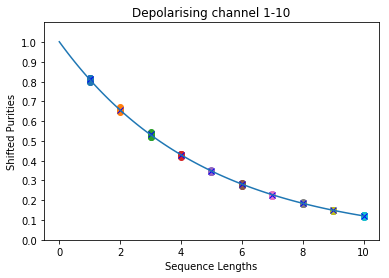

0.8093744140350309

In [4]:
experiment = URB(output_folder_name = 'Results\\Depolarising channel simulations\\Single Qubit', num_qubits = 1, shots = 1024)
experiment.runURB([1,2,3,4,5,6,7,8,9,10],10,5,"Depolarising channel 1-10", clifford_error_1 = clifford_error_1)

#### Calculate variance and mean unitarity over large number of iterations and samples (for confidence estimates) 

Experiments for depth  1  has begun...............................
  |-> Iteration  1 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  1 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence...

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  2  for depth  4 ..............
      |-> Pauli Gate index f

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

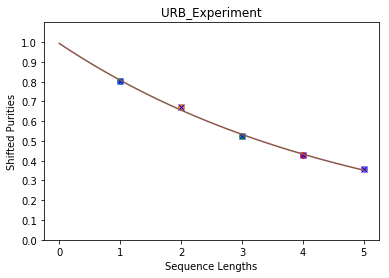

Experiments for depth  1  has begun...............................
  |-> Iteration  1 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  1 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence...

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  3  for depth  3 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Ap

        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index  4  finished for Iteration:  1  depth:  4
   |-> Iteration:  1  finished for depth  4  ............................
XXXXXXXXX Depth  4 complete XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Experiments for depth  5  has begun...............................
  |-> Iteration  1 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gat

          |-> Batch  2  Executed on backend.............................
        |-> Experiments executed !!XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXX URB SUCCESSFUL XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Summary 
 Avg_shifted_purities:  [0.8049478530883789, 0.6603116989135742, 0.543738047281901, 0.4406677881876628, 0.33914947509765625] 
 Depths:  [1, 2, 3, 4, 5] Time elapsed:  0.0016293329662746853
Plotting curves and Calculating Unitarity
Unitarity of the noise channel:  0.8079061459957596
Plot of purities vs depth of the circuit with the curve showing the relationship between empirical average shifted purity and depth of the circuit 


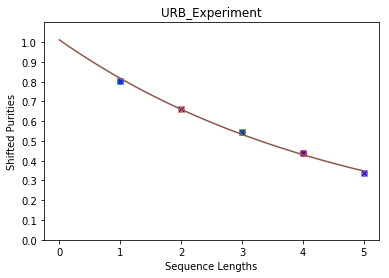

Experiments for depth  1  has begun...............................
  |-> Iteration  1 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  1 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence...

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  3  for depth  2 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful......

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

          |-> Batch  2  Executed on backend.............................
        |-> Experiments executed !!XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXX URB SUCCESSFUL XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Summary 
 Avg_shifted_purities:  [0.7992540995279948, 0.6602640151977539, 0.5101000467936198, 0.4293785095214844, 0.3634649912516276] 
 Depths:  [1, 2, 3, 4, 5] Time elapsed:  0.0016559213399887085
Plotting curves and Calculating Unitarity
Unitarity of the noise channel:  0.8182157033184936
Plot of purities vs depth of the circuit with the curve showing the relationship between empirical average shifted purity and depth of the circuit 


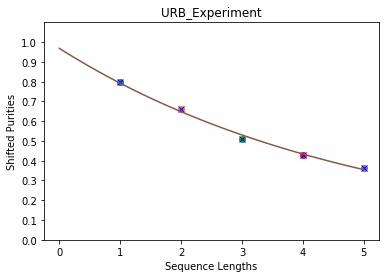

Experiments for depth  1  has begun...............................
  |-> Iteration  1 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  1 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence...

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  3  for depth  2 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Ap

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

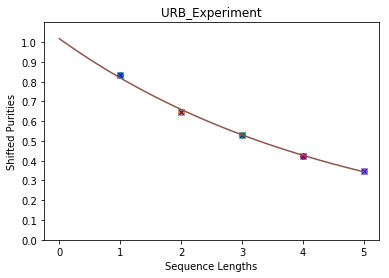

Experiments for depth  1  has begun...............................
  |-> Iteration  1 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  1 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence...

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  4 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful..

        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  5 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful..

          |-> Batch  2  Executed on backend.............................
        |-> Experiments executed !!XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXX URB SUCCESSFUL XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Summary 
 Avg_shifted_purities:  [0.7948424021402994, 0.6456788380940756, 0.5206193923950195, 0.45116837819417316, 0.3517300287882487] 
 Depths:  [1, 2, 3, 4, 5] Time elapsed:  0.0014686581823560928
Plotting curves and Calculating Unitarity
Unitarity of the noise channel:  0.8196300907340959
Plot of purities vs depth of the circuit with the curve showing the relationship between empirical average shifted purity and depth of the circuit 


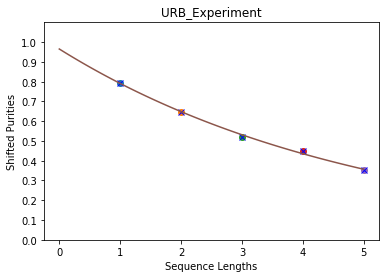

Experiments for depth  1  has begun...............................
  |-> Iteration  1 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  1 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence...

        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  2  for depth  2 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful......

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  5 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful..

          |-> Batch  2  Executed on backend.............................
        |-> Experiments executed !!XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXX URB SUCCESSFUL XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Summary 
 Avg_shifted_purities:  [0.7975349426269531, 0.6660912831624349, 0.5473286310831705, 0.43180370330810547, 0.34608936309814453] 
 Depths:  [1, 2, 3, 4, 5] Time elapsed:  0.0017187417215771144
Plotting curves and Calculating Unitarity
Unitarity of the noise channel:  0.8103319590241611
Plot of purities vs depth of the circuit with the curve showing the relationship between empirical average shifted purity and depth of the circuit 


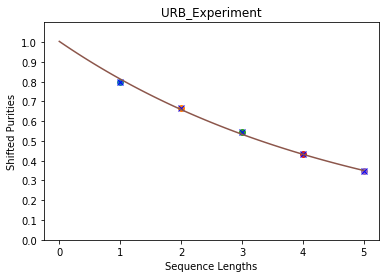

Experiments for depth  1  has begun...............................
  |-> Iteration  1 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  1 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence...

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index  4  finished for Iteration:  1  depth:  4
   |-> Iteration:  1  finished for depth  4  ............................
XXXXXXXXX Depth  4 complete XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Experiments for depth  5  has begun...............................
  |-> Iteration  1 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  5 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence............

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index  4  finished for Iteration:  1  depth:  5
   |-> Iteration:  1  finished for depth  5  ............................
XXXXXXXXX Depth  5 complete XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXCircuits Initialized for URBXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
        |-> Sendin

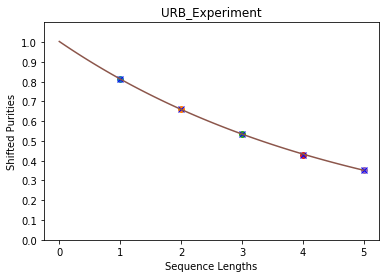

Experiments for depth  1  has begun...............................
  |-> Iteration  1 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  1 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence...

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sampl

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  2  for depth  5 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Ap

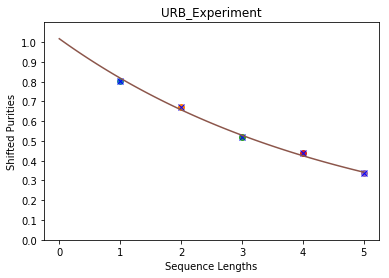

Experiments for depth  1  has begun...............................
  |-> Iteration  1 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  1 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence...

    |-> Pauli Gate index for state preparation:  3  for depth  2 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index f

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

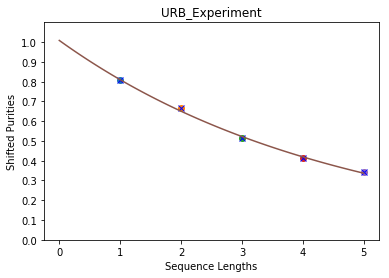

Experiments for depth  1  has begun...............................
  |-> Iteration  1 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  1 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence...

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

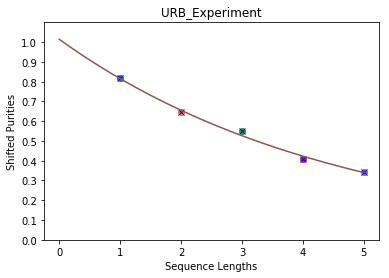

Experiments for depth  1  has begun...............................
  |-> Iteration  1 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  1 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence...

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence......

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

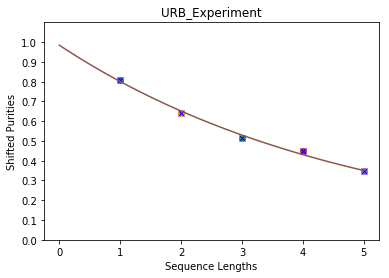

Experiments for depth  1  has begun...............................
  |-> Iteration  1 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  1 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence...

        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  3 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  2  for depth  5 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Ap

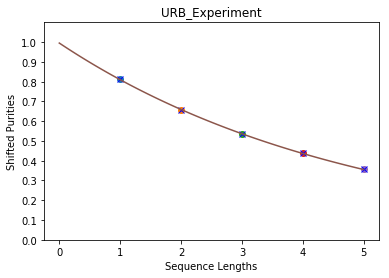

Experiments for depth  1  has begun...............................
  |-> Iteration  1 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  1 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence...

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
    |-> Pauli Gate index for state preparation:  3  for depth  3 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Ap

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

          |-> Batch  2  Executed on backend.............................
        |-> Experiments executed !!XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXX URB SUCCESSFUL XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Summary 
 Avg_shifted_purities:  [0.8073237737019857, 0.6543471018473307, 0.5308065414428711, 0.43312517801920575, 0.34129174550374347] 
 Depths:  [1, 2, 3, 4, 5] Time elapsed:  0.0015716538164350722
Plotting curves and Calculating Unitarity
Unitarity of the noise channel:  0.807785649045024
Plot of purities vs depth of the circuit with the curve showing the relationship between empirical average shifted purity and depth of the circuit 


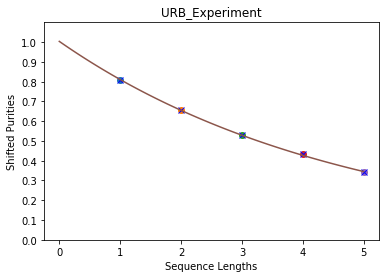

Experiments for depth  1  has begun...............................
  |-> Iteration  1 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  1 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence...

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

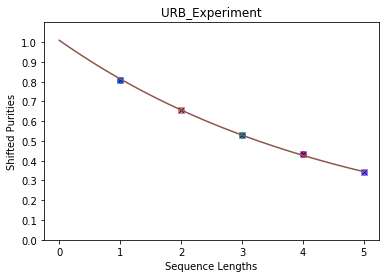

Experiments for depth  1  has begun...............................
  |-> Iteration  1 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  1 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence...

        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  3 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters..

        |-> Successful.................................
    |-> Pauli Gate index  4  finished for Iteration:  1  depth:  3
   |-> Iteration:  1  finished for depth  3  ............................
XXXXXXXXX Depth  3 complete XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Experiments for depth  4  has begun...............................
  |-> Iteration  1 ...........................
        |-> Generating Random Gate Sequence................
        |-> Random Sequence Generated......................
    |-> Pauli Gate index for state preparation:  1  for depth  4 ..............
      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.....................

      |-> Pauli Gate index for measurement:  1 Sample number:  0
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  1 Sample number:  1
        |-> Initialization of the experiment has begun...............
        |-> Successful.....................................
        |-> Applying Sampled Gate Sequence..................
        |-> Gate Sequence Applied...........................
        |-> Extracting Measurement parameters.......................... 
        |-> Successful.................................
      |-> Pauli Gate index for measurement:  2 Sample number:  0
        |-> Initialization of the experimen

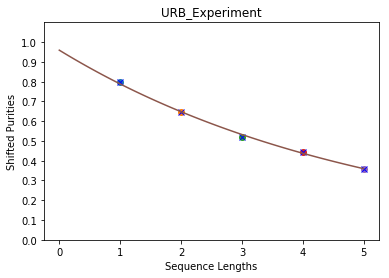



 Variance in the URB experiment 3.528716607293696e-05


In [5]:
unitarities = []
iterations = 15
for _ in range(iterations):
    exp = URB()
    unitarities.append(exp.runURB([1,2,3,4,5], 1, 2, clifford_error_1 = clifford_error_1))
mean_unitarity = sum(unitarities)/iterations
squared_unitarities = [(value - mean_unitarity)*(value - mean_unitarity) for value in unitarities]
variance = sum(squared_unitarities)/(iterations - 1)
print("\n\n Variance in the URB experiment", variance)